In [1]:
cd /home/blansdel/projects/behaveml

/home/blansdel/projects/behaveml


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:

from glob import glob 
from behaveml import VideosetDataFrame, clone_metadata
from behaveml import mars_feature_maker, cnn_probability_feature_maker, interpolate_lowconf_points

#A list of DLC tracking files
tracking_files = sorted(glob('./tests/data/dlc/*.csv'))

#A list of BORIS labeled files, ordered to correspond with DLC tracking file list
boris_files = sorted(glob('./tests/data/boris/*.csv'))

#A list of video files, ordered to correspond with DLC tracking file list
video_files = sorted(glob('./tests/data/videos/*.avi'))

frame_length = None              # (float) length of entire horizontal shot
units = None                     # (str) units frame_length is given in
fps = 30                         # (int) frames per second
resolution = (1200, 1600)        # (tuple) HxW in pixels

#Metadata is a dictionary that attaches each of the above parameters to the video/behavior annotations
metadata = clone_metadata(tracking_files, 
                          label_files = boris_files, 
                          video_files = video_files,
                          frame_length = frame_length, 
                          fps = fps, 
                          units = units, 
                          resolution = resolution)

dataset = VideosetDataFrame(metadata)

#Filter out low-confidence DLC tracks and interpolate those points instead
print("Interpolating low-confidence tracking points")
interpolate_lowconf_points(dataset)

#Now create features on this dataset
print("Calculating MARS features")
dataset.add_features(mars_feature_maker, 
                     featureset_name = 'MARS', 
                     add_to_features = True)

#Note: by default this keras code will try to use CUDA. 
print("Calculating 1D CNN pretrained network features")
dataset.add_features(cnn_probability_feature_maker, 
                     featureset_name = '1dcnn', 
                     add_to_features = True)

Interpolating low-confidence tracking points
processing ./tests/data/dlc/e3v813a-20210610T120637-121213DLC_dlcrnetms5_pilot_studySep24shuffle1_100000_el_filtered.csv
processing ./tests/data/dlc/e3v813a-20210610T121558-122141DLC_dlcrnetms5_pilot_studySep24shuffle1_100000_el_filtered.csv
processing ./tests/data/dlc/e3v813a-20210610T122332-122642DLC_dlcrnetms5_pilot_studySep24shuffle1_100000_el_filtered.csv
processing ./tests/data/dlc/e3v813a-20210610T122758-123309DLC_dlcrnetms5_pilot_studySep24shuffle1_100000_el_filtered.csv
processing ./tests/data/dlc/e3v813a-20210610T123521-124106DLC_dlcrnetms5_pilot_studySep24shuffle1_100000_el_filtered.csv
Calculating MARS features
Calculating 1D CNN pretrained network features
Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.0001, layer_channels: (128, 64, 64), conv_size: 5


  0%|          | 0/6 [00:00<?, ?it/s]

Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.0001, layer_channels: (128, 64, 64), conv_size: 5


  0%|          | 0/6 [00:00<?, ?it/s]

Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.0001, layer_channels: (128, 64, 64), conv_size: 5


  0%|          | 0/6 [00:00<?, ?it/s]

Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.0001, layer_channels: (128, 64, 64), conv_size: 5


  0%|          | 0/6 [00:00<?, ?it/s]

Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.0001, layer_channels: (128, 64, 64), conv_size: 5


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [5]:
print("Adding likelihood columns")
dataset.feature_cols += list(dataset.data.columns[28:42])

Adding likelihood columns


In [21]:
dataset.feature_cols

['MARS__centroid_all_adult_x',
 'MARS__centroid_all_adult_y',
 'MARS__centroid_all_juvenile_x',
 'MARS__centroid_all_juvenile_y',
 'MARS__centroid_all_adult_y_min_pm_1',
 'MARS__centroid_all_juvenile_y_min_pm_1',
 'MARS__centroid_all_juvenile_x_min_pm_1',
 'MARS__centroid_all_adult_x_min_pm_1',
 'MARS__centroid_all_adult_y_max_pm_1',
 'MARS__centroid_all_juvenile_y_max_pm_1',
 'MARS__centroid_all_juvenile_x_max_pm_1',
 'MARS__centroid_all_adult_x_max_pm_1',
 'MARS__centroid_all_adult_y_std_pm_1',
 'MARS__centroid_all_juvenile_y_std_pm_1',
 'MARS__centroid_all_juvenile_x_std_pm_1',
 'MARS__centroid_all_adult_x_std_pm_1',
 'MARS__centroid_all_adult_y_mean_pm_1',
 'MARS__centroid_all_juvenile_y_mean_pm_1',
 'MARS__centroid_all_juvenile_x_mean_pm_1',
 'MARS__centroid_all_adult_x_mean_pm_1',
 'MARS__centroid_all_adult_y_min_pm_5',
 'MARS__centroid_all_juvenile_y_min_pm_5',
 'MARS__centroid_all_juvenile_x_min_pm_5',
 'MARS__centroid_all_adult_x_min_pm_5',
 'MARS__centroid_all_adult_y_max_pm_

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

from behaveml.models import F1Optimizer, HMMSklearn, ModelTransformer

splitter = GroupKFold(n_splits = dataset.n_videos)
model = RandomForestClassifier()

In [9]:
print("Fitting ML model with (group) LOO CV")
predictions = cross_val_predict(RandomForestClassifier(), 
                                dataset.features, 
                                dataset.labels, 
                                groups = dataset.group, 
                                cv = splitter,
                                verbose = 1,
                                n_jobs = 5)

Fitting ML model with (group) LOO CV


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.4min finished


In [10]:
#Append these for later use
dataset.data['prediction'] = predictions
acc = accuracy_score(dataset.labels, predictions)
f1 = f1_score(dataset.labels, predictions)
pr = precision_score(dataset.labels, predictions)
re = recall_score(dataset.labels, predictions)
print("Acc", acc, "F1", f1, 'precision', pr, 'recall', re)


Acc 0.9348838225972153 F1 0.703906172348673 precision 0.7846222025260359 recall 0.6382480173035328


## Embedding

In [18]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [23]:
dataset.feature_cols

['MARS__centroid_all_adult_x',
 'MARS__centroid_all_adult_y',
 'MARS__centroid_all_juvenile_x',
 'MARS__centroid_all_juvenile_y',
 'MARS__centroid_all_adult_y_min_pm_1',
 'MARS__centroid_all_juvenile_y_min_pm_1',
 'MARS__centroid_all_juvenile_x_min_pm_1',
 'MARS__centroid_all_adult_x_min_pm_1',
 'MARS__centroid_all_adult_y_max_pm_1',
 'MARS__centroid_all_juvenile_y_max_pm_1',
 'MARS__centroid_all_juvenile_x_max_pm_1',
 'MARS__centroid_all_adult_x_max_pm_1',
 'MARS__centroid_all_adult_y_std_pm_1',
 'MARS__centroid_all_juvenile_y_std_pm_1',
 'MARS__centroid_all_juvenile_x_std_pm_1',
 'MARS__centroid_all_adult_x_std_pm_1',
 'MARS__centroid_all_adult_y_mean_pm_1',
 'MARS__centroid_all_juvenile_y_mean_pm_1',
 'MARS__centroid_all_juvenile_x_mean_pm_1',
 'MARS__centroid_all_adult_x_mean_pm_1',
 'MARS__centroid_all_adult_y_min_pm_5',
 'MARS__centroid_all_juvenile_y_min_pm_5',
 'MARS__centroid_all_juvenile_x_min_pm_5',
 'MARS__centroid_all_adult_x_min_pm_5',
 'MARS__centroid_all_adult_y_max_pm_

In [24]:
tsne_cols = ['1dcnn__prob_attack',
                '1dcnn__prob_investigation',
                '1dcnn__prob_mount',
                '1dcnn__prob_other',
                'likelihood_adult_nose',
                'likelihood_adult_leftear',
                'likelihood_adult_rightear',
                'likelihood_adult_neck',
                'likelihood_adult_lefthip',
                'likelihood_adult_righthip',
                'likelihood_adult_tail',
                'likelihood_juvenile_nose',
                'likelihood_juvenile_leftear',
                'likelihood_juvenile_rightear',
                'likelihood_juvenile_neck',
                'likelihood_juvenile_lefthip',
                'likelihood_juvenile_righthip',
                'likelihood_juvenile_tail']
tsne_embedding = TSNE(n_components=2, init = 'pca').fit_transform(dataset.data[tsne_cols])


In [28]:
import numpy as np

In [26]:
cnn_cols = ['1dcnn__prob_attack',
                '1dcnn__prob_investigation',
                '1dcnn__prob_mount',
                '1dcnn__prob_other']

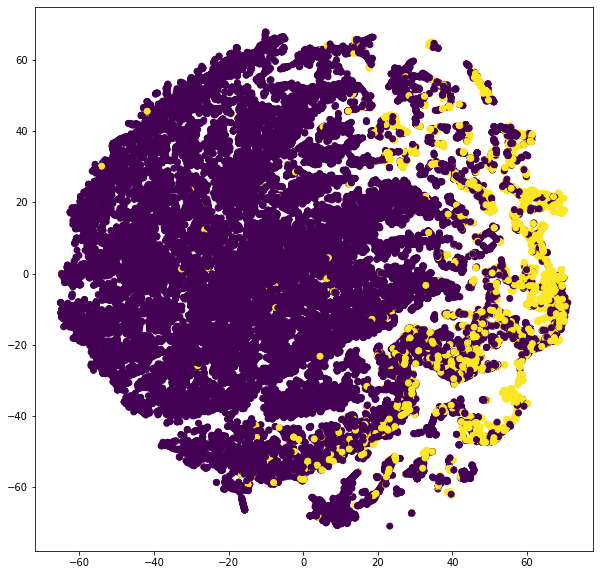

In [25]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(x = tsne_embedding[:,0], y = tsne_embedding[:,1], c = dataset.labels)

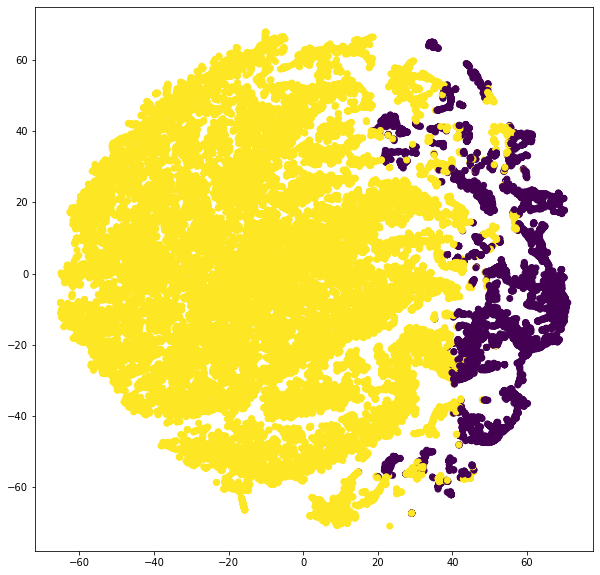

In [34]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(x = tsne_embedding[:,0], y = tsne_embedding[:,1], c = np.argmax(dataset.data[cnn_cols].to_numpy(), axis = -1))

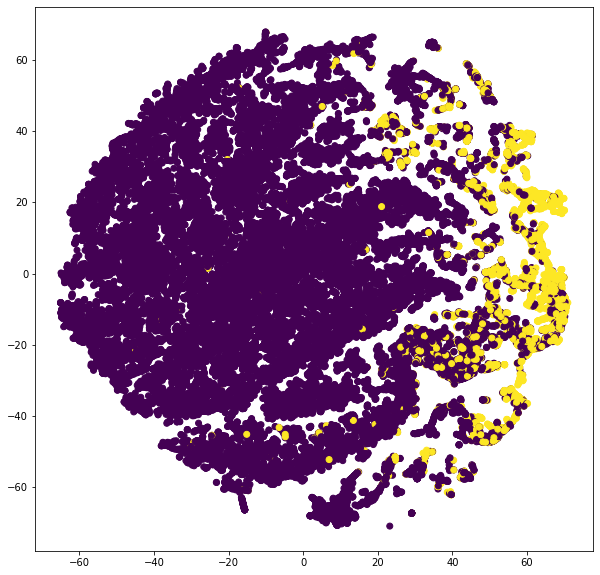

In [36]:
fig, axes = plt.subplots(1,1, figsize = (10,10))
axes.scatter(x = tsne_embedding[:,0], y = tsne_embedding[:,1], c = dataset.data['prediction'])